In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/KUIAI

/content/drive/.shortcut-targets-by-id/10MlAIe-Y5g7Gs8xPaR5j0JGadAlZKdyB/KUIAI


## import packages


In [ ]:
  from urllib.request import urlopen
  from urllib.parse import quote_plus
  from bs4 import BeautifulSoup as soup
  from selenium import webdriver as wd
  from selenium.webdriver.common.by import By
  from selenium.webdriver.support.ui import WebDriverWait
  from selenium.webdriver.support import expected_conditions as EC
  from selenium.webdriver.common.keys import Keys
  from fake_useragent import UserAgent
  from selenium.webdriver.chrome.options import Options
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
  import openpyxl
  import time
  import os
  import re
  import json
  import pandas as pd
  import numpy as np
  import multiprocessing as mp
  from multiprocessing import Process
  import datetime

In [ ]:
inf_account_list = pd.read_csv('./data/인플루언서ID_리스트.csv', header=None)
inf_account_list.info()
inf_account_list.loc[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


0    @by_he.nique
Name: 0, dtype: object

In [ ]:
inf_account_list = inf_account_list[0].values.tolist()

In [ ]:
#경로 내 폴더가 있는지 확인하고, 없다면 폴더를 만드는 함수
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## 인플루언서 피드 수 확인

In [ ]:
user_id="crawling7138"
user_passwd="matt7453!!"
driver_path="~/chromedriver"
instagram_id_name="username"
instagram_pw_name="password"

instagram_login_btn='//*[@id="loginForm"]/div/div[3]/button'

Feed_num_df = pd.DataFrame("", index=np.arange(1,101), columns = ['account', 'Feed'])
options = Options()
options.add_argument(f'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36')
driver = wd.Chrome(options=options)

print(f"login start - option instagram")

login_url = "https://www.instagram.com/accounts/login/"
driver = wd.Chrome()
driver.get(login_url)
time.sleep(10)

#instagram으로 로그인
try:
    instagram_id_form = driver.find_element(By.NAME, instagram_id_name)
    instagram_id_form.send_keys(user_id)
    time.sleep(3)

    instagram_pw_form = driver.find_element(By.NAME, instagram_pw_name)
    instagram_pw_form.send_keys(user_passwd)
    time.sleep(3)
        
    login_ok_button = driver.find_element(By.XPATH, instagram_login_btn)
    login_ok_button.click()
    is_login_success = True
    print("instagram login success")
except:
    print("instagram login fail")
    is_login_success = False

time.sleep(10)

i=0
error = 0
for profile in inf_account_list :
    try :
        link_profile = profile.replace('@', '')
        profile_Url = 'https://www.instagram.com/'+ link_profile +'/'
        driver.get(profile_Url)
        time.sleep(7)

        Feed_num_space = driver.find_element(By.XPATH,'//li[@class=" xl565be    x2pgyrj  x1m39q7l x1uw6ca5"]')
        time.sleep(1)
        Feed_num = Feed_num_space.find_element(By.XPATH, '//span[@class="_ac2a"]/span').text
        print(Feed_num)

        Feed_num_df.iloc[i, 0] = profile
        Feed_num_df.iloc[i, 1] = Feed_num
        print(i,'번째 계정 완료', profile, Feed_num)
        i += 1 
    except:
        error +=1
        pass

print('end and error occur : ', error)



In [ ]:
#인플루언서 피드 수 계산 결과 전처리 및 엑셀 파일화
Feed_num_df=Feed_num_df[Feed_num_df['account'].isna() == False][:] # 존재하지 않는 계정 행 제거
Feed_num_df['Feed']=Feed_num_df['Feed'].astype(int)
print(Feed_num_df.describe())
Feed_num_df.to_excel("./Feed_num_results.xlsx")

## multiprocessing data crawling

In [ ]:
#인플루언서 피드 수 계정을 불러와서 8개로 나누기
inf_account_feed_df = pd.read_excel('./Feed_num_results.xlsx')
print(inf_account_feed_df.info())

inf_account_feed_1 = inf_account_feed_df.iloc[0:17, :]
inf_account_feed_2 = inf_account_feed_df.iloc[17:34,:]
inf_account_feed_3 = inf_account_feed_df.iloc[34:50,:]
inf_account_feed_4 = inf_account_feed_df.iloc[50:64,:]
inf_account_feed_5 = inf_account_feed_df.iloc[64:83,:]
inf_account_feed_6 = inf_account_feed_df.iloc[83:98,:]
inf_account_feed_7 = inf_account_feed_df.iloc[73:85,:]
inf_account_feed_8 = inf_account_feed_df.iloc[85:98,:]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  98 non-null     int64 
 1   account     98 non-null     object
 2   Feed        98 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 2.4+ KB
None


In [ ]:
def crawling(id, pw, inf_account_feed_df) :

    user_id=id
    user_passwd=pw
    driver_path="~/chromedriver"
    instagram_id_name="username"
    instagram_pw_name="password"
    instagram_login_btn='//*[@id="loginForm"]/div/div[3]/button'

    #inf_account_feed_df = pd.read_excel('./Feed_num_results.xlsx')

    hashtag_df = pd.DataFrame("", index=np.arange(1,3000), 
                                columns = ['account', 'date', 'like', 'comment', 'body', 'instagram_tags'])

    stop_words = ['#인스타패션', '#패션스타그램', '#데일리코디', '#데일리패션', '#ootd', '#데일리', '#daily', '#dailylook', '#자체제작', '#쇼핑몰', '#자체제작쇼핑몰' 
                    ,'#코디모음', '#오오티디', '#이벤트', '#할인', '#좋아요', '#좋반', '#좋아요반사', '#오늘의코디']


    options = Options()
    options.add_argument(f'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36')
    driver = wd.Chrome(options=options)

    print(f"login start - option instagram")

    login_url = "https://www.instagram.com/accounts/login/"
    driver.get(login_url)

    time.sleep(8)

    #instagram으로 로그인
    try:
        instagram_id_form = driver.find_element(By.NAME, instagram_id_name)
        instagram_id_form.send_keys(user_id)
        time.sleep(3)

        instagram_pw_form = driver.find_element(By.NAME, instagram_pw_name)
        instagram_pw_form.send_keys(user_passwd)
        time.sleep(3)
            
        login_ok_button = driver.find_element(By.XPATH, instagram_login_btn)
        login_ok_button.click()
        is_login_success = True
        print("instagram login success")
    except:
        print("instagram login fail")
        is_login_success = False

    time.sleep(8)

    next_name = 'div._aaqg._aaqh > button'
    tag_name = 'span._aacl._aaco._aacu._aacx._aad7._aade > a'
    image_name = '//div[@class="_ab8w  _ab94 _ab99 _ab9h _ab9k _ab9p _abcm"]//img'
    body = '//div[@class="_a9zn _a9zo"]//span[@class="_aacl _aaco _aacu _aacx _aad7 _aade"]'
    more_btn = '//li[@class="_a9yg"]//button'
    #'//button[@class="_acan _aiit _acao _aija _acas _aj1-"]'

    error = 0
    p = 0

    print(inf_account_feed_df['account'])
    for profile in inf_account_feed_df['account'] :
        num = inf_account_feed_df[inf_account_feed_df['account'] == profile]['Feed']
        stepsize = num.item() // 40
        if stepsize >= 30 :
            stepsize = 30
        try : 
            instagram_tags = []
            
            link_profile = profile.replace('@', '')
            profile_Url = 'https://www.instagram.com/'+ link_profile +'/'
            driver.get(profile_Url)

            WebDriverWait(driver,10).until(EC.presence_of_element_located((By.CSS_SELECTOR,'div._aabd._aa8k._aanf')))

            #첫번째 게시글 선택
            driver.find_element(By.CSS_SELECTOR,'div._aabd._aa8k._aanf').click()

        except :
            print('not exist account')
            error += 1
            continue

        time.sleep(10)
        
        #account 데이터 기록
        account_text = profile

        for i in range(20):

            # 날짜 기록
            try : 
                date = driver.find_element(By.CSS_SELECTOR, "time._a9ze._a9zf").get_attribute("datetime") # 날짜 선택
            except :
                date = 'error'
                error += 1
                pass
            try :    
                # 해쉬태그 데이터 기록
                # 답글 더보기 버튼 클릭
                morelist = driver.find_elements(By.XPATH, more_btn)
                for t in range(len(morelist)) :
                    morelist[t].send_keys(Keys.ENTER)
                    time.sleep(3)
                time.sleep(10)
            except :
                error += 1
                pass
            try :
                # 해쉬태그가 있는 element들을 모아서 list에 저장
                list = driver.find_elements(By.CSS_SELECTOR, tag_name)

                hashtag_data = []

                for k in range(len(list)):
                    hashtag = list[k].text #각각의 element에서 text 추출
                    hashtag_data.append(hashtag)
                
                #의미없는 태그를 제거
                temp_tags = [hashtag for hashtag in hashtag_data if (hashtag not in stop_words) & (not hashtag.startswith('@'))]
                instagram_tags = []
                #중복된 태그를 제거
                [instagram_tags.append(x) for x in temp_tags if x not in instagram_tags]
            except :
                error += 1
                pass

            # 각 게시글 별 좋아요, 댓글 수 기록
            try :
                like_number = driver.find_element(By.XPATH, '//div[@class="_aacl _aaco _aacw _aacx _aada _aade"]/span').text
                comment_number = len(driver.find_elements(By.XPATH, '//ul[@class="_a9ym"]'))
            except :
                error += 1
                like_number = 'error'
                comment_number = 'error'
                pass
            try :
                body_text = driver.find_element(By.XPATH, body).text
            except : 
                error += 1
                body_text = 'error'
                pass
            
            # 각 게시글 별 첫번째 이미지 저장
            # 각 인플루언서 별 저장할 폴더 check 후 생성
            try :
                createFolder('./img/'+ profile)

                imgUrl = driver.find_element(By.XPATH, image_name).get_attribute('src')
                with urlopen(imgUrl) as f :
                    with open('./img/' +  profile + '/' + str(p) + '.jpg', 'wb') as h :
                        img = f.read()
                        h.write(img)
            except :
                error += 1
                pass
            
            if (i+1)%5 == 0 : 
                print('{}, {}번째 게시물 탐색 완료'.format(time.strftime('%c', time.localtime(time.time())), i+1))
                print('error count : ', error)
                
            # dataframe 저장
            hashtag_df.iloc[p, 0] = account_text
            hashtag_df.iloc[p, 1] = date
            hashtag_df.iloc[p, 2] = like_number
            hashtag_df.iloc[p, 3] = comment_number
            hashtag_df.iloc[p, 4] = body_text
            hashtag_df.iloc[p, 5] = instagram_tags
            print(hashtag_df.iloc[p,:])
            print(p)
            
            # 최대 5초까지 기다렸다가, > 모양 클릭하여 다음 게시물로 넘어가기
            try :
                for step in range(stepsize):
                    WebDriverWait(driver,5).until(EC.presence_of_element_located((By.CSS_SELECTOR, next_name)))
                    driver.find_element(By.CSS_SELECTOR, next_name).send_keys(Keys.ENTER)
                    time.sleep(3)
            except :
                print('error occur')
                error += 1
                pass

            p += 1
            if p%10 == 0 :
                hashtag_df.to_excel("./results_"+id+".xlsx")
                print(p,'개 출력 error count : ', error)

    # 결과값 저장
    driver.quit()
    hashtag_df.to_excel("./results_"+id+".xlsx")
    print('error count : ', error)

divide =[('crawling713838','matt7453!!',inf_account_feed_1),('crawling745353','matt7453!!',inf_account_feed_2),('crawling745338','matt7453!!',inf_account_feed_3),('crawling713853','matt7453!!',inf_account_feed_4),
        ('bayesihwan_dist','rjsdnghkdlxld!',inf_account_feed_5), ('yellowjesus2023','rjsdnghkdlxld!',inf_account_feed_6),
        ('ireallywanttostay','kuiai!',inf_account_feed_7),('hotflatcrowded','kuiai!',inf_account_feed_8)]

def multiprocess():

    start = int(time.time())
    ojbect_list = []
    for id, pw, df in divide:

        task = Process(target=crawling, args=(id, pw, df))

        ojbect_list.append(task)

        task.start()
        
    for task in ojbect_list:

        task.join()
    end = int(time.time())

    print("***run time(sec) : ", end-start)   
    print("Number of Core : " + str(mp.cpu_count()))

if __name__ == '__main__':
    multiprocess() #cmd -> py 실행

In [ ]:
#크롤링 데이터 병합
#본문 데이터에서 해시태그를 추출

result_df_list = ['results-crawling713853.xlsx','results-crawling745338.xlsx','results-crawling745353.xlsx','results-ireallywanttostay.xlsx','results-yellowjesus2023.xlsx', 'results-bayesihwan_dist.xlsx', 'results-crawling713838.xlsx']
crawling713853 = pd.read_excel('./results-crawling713853.xlsx')
crawling745338 = pd.read_excel('./results-crawling745338.xlsx')
crawling745353 = pd.read_excel('./results-crawling745353.xlsx')
ireallywanttostay = pd.read_excel('./results-ireallywanttostay.xlsx')
yellowjesus2023 = pd.read_excel('./results-yellowjesus2023.xlsx')
crawling713838 = pd.read_excel('./results-crawling713838.xlsx')
bayesihwan_dist = pd.read_excel('./results-bayesihwan_dist.xlsx')
hotflatcrowded = pd.read_excel('./results-hotflatcrowded.xlsx')
result_concat_df = pd.concat([crawling713853,crawling745338,crawling745353,ireallywanttostay,yellowjesus2023,bayesihwan_dist,crawling713838,hotflatcrowded],ignore_index=True)

result_concat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23992 entries, 0 to 23991
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  23992 non-null  int64 
 1   account     1960 non-null   object
 2   date        1960 non-null   object
 3   like        1860 non-null   object
 4   comment     1960 non-null   object
 5   body        1836 non-null   object
 6   t1          158 non-null    object
 7   t2          160 non-null    object
 8   t3          160 non-null    object
 9   t4          160 non-null    object
 10  t5          160 non-null    object
 11  t6          160 non-null    object
 12  t7          160 non-null    object
 13  t8          160 non-null    object
 14  t9          160 non-null    object
 15  t10         160 non-null    object
 16  t11         160 non-null    object
 17  t12         159 non-null    object
 18  t13         159 non-null    object
 19  t14         159 non-null    object
 20  t15   

In [ ]:
pre_result_concat_df = result_concat_df[result_concat_df['account'].isna() == False][:]
pre_result_concat_df.drop('Unnamed: 0', axis=1, inplace=True)
print(pre_result_concat_df.columns)
no_tag_result_df = pre_result_concat_df.copy()
no_tag_result_df = no_tag_result_df.reset_index()
no_tag_result_df = no_tag_result_df[['account', 'date', 'like', 'comment', 'body']]
print(no_tag_result_df.head())

Index(['account', 'date', 'like', 'comment', 'body', 't1', 't2', 't3', 't4',
       't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15'],
      dtype='object')
      account                      date  like comment  \
0  @odor_bubu  2022-10-01T09:17:25.000Z  2213      20   
1  @odor_bubu  2022-12-14T10:01:46.000Z   984      20   
2  @odor_bubu  2022-11-19T04:23:58.000Z   890      20   
3  @odor_bubu  2022-10-17T01:46:30.000Z   777      20   
4  @odor_bubu  2022-09-14T00:21:54.000Z   793      20   

                                                body  
0  🥘 영건이가 쓰는 글\n.\n오늘은…\n마라탕이 먹고싶었다.\n쌀쌀해진 날씨를 어필...  
1  👟#협찬 영건이가 쓰는 글\n.\n증말 춥네요. 추워도 따뜻한 소식들\n준비중이라 ...  
2  🕺🏻#광고 @gramicci_kr #그라미치\n영건이가 쓰는 글\n.\n오늘 토요일...  
3  👢#협찬 영건이가 쓰는 글\n.\n10년뒤면, 40대로 접어든다.\n그때에도 여전히...  
4  🍙 #제품제공 은성이가 쓰는 글\n영건이와 함께\n일찍 맞이한 에프떠블유 옷.\n....  


In [ ]:
#텍스트 데이터 전처리
def text_preprocessor(s):
    import re
    
    ## (1) [], (), {}, <> 괄호와 괄호 안 문자 제거하기
    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\[[^)]*\]'  # []
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\<[^)]*\>'  # <>
    s = re.sub(pattern=pattern, repl='', string=s)
    
    pattern = r'\{[^)]*\}'  # {}
    s = re.sub(pattern=pattern, repl='', string=s)
    
    ## (2) '...외', '...총' 제거하기
    s = s.replace('...외', ' ')
    s = s.replace('...총', ' ')
    
    ## (3) 특수문자 제거
    pattern = r'[^#a-zA-Z가-힣]' #'#'은 제외
    s = re.sub(pattern=pattern, repl=' ', string=s)
    
    ## (4) 단위 제거: cm, km, etc.
    units = ['mm', 'cm', 'km', 'ml', 'kg', 'g']
    for unit in units:
        s = s.lower() # 대문자를 소문자로 변환
        s = s.replace(unit, '')
        
    # (5) 공백 기준으로 분할하기
    s_split = s.split()
    
    # (6) 글자 1개만 있으면 제외하기
    s_list = []
    for word in s_split:
        if len(word) !=1:
            s_list.append(word)
            
    return s_list

In [ ]:
#전처리 함수 사용하여 본문 데이터를 담고 있는 body 열을 문자열 전처리
no_tag_result_df['body'] = no_tag_result_df['body'].str.replace("\n", " ")
no_tag_result_df['pre_body'] = no_tag_result_df['body'].apply(lambda s : text_preprocessor(str(s)))

#본문의 해시태그 추출
for i in range(len(no_tag_result_df)) :
    tag_li = []
    for word in no_tag_result_df['pre_body'][i] :
        if '#' in word:
            tag_li.append(word)
    no_tag_result_df.at[i,'body'] = tag_li

no_tag_result_df['pre_body'] = no_tag_result_df['pre_body'].apply(lambda s : ' '.join(s))
no_tag_result_df.columns = ['account', 'date', 'like', 'comment', 'tag', 'pre_body']
no_tag_result_df.head()

,account,date,like,comment,tag,pre_body
0,@odor_bubu,2022-10-01T09:17:25.000Z,2213,20,"[#내돈내산, #잡화점서울]",영건이가 쓰는 오늘은 마라탕이 먹고싶었다 쌀쌀해진 날씨를 어필해 은성이에게 마라탕을...
1,@odor_bubu,2022-12-14T10:01:46.000Z,984,20,"[#협찬, #스웻팬츠, #개파카, #발마칸코트, #스니커즈, #스니커즈코디, #원마...",#협찬 영건이가 쓰는 증말 춥네요 추워도 따뜻한 소식들 준비중이라 웃음꽃피는 요즘입...
2,@odor_bubu,2022-11-19T04:23:58.000Z,890,20,"[#광고, #그라미치, #더현대서울, #코듀로이, #패딩, #ramicci, #그라...",#광고 ramicci kr #그라미치 영건이가 쓰는 오늘 토요일 날씨는 증말 더현대...
3,@odor_bubu,2022-10-17T01:46:30.000Z,777,20,"[#협찬, #블런드스톤]",#협찬 영건이가 쓰는 년뒤면 대로 접어든다 그때에도 여전히 은성이랑 이렇게 사진을 ...
4,@odor_bubu,2022-09-14T00:21:54.000Z,793,20,"[#제품제공, #physicaleducationdept, #phyps, #피지컬에듀...",#제품제공 은성이가 쓰는 영건이와 함께 일찍 맞이한 에프떠블유 영건이는 자켓이 맘에...


In [ ]:
#예시
list(no_tag_result_df[no_tag_result_df['account']=='@yeenstyle_']['pre_body'])

['잘가',
 '다들 새해 많이 받으세욤 건조한 겨울 수분관리에 딱인 토너패드 #토너패드 #수분패드 #앰플패드 #멀티밤 #구일',
 '#광고 길가다가 지나가던 사람들이 샴푸 쓰냐고 물어봐요',
 '#협찬 향기 너무 좋자나여 손상된 모발에 영양이 깊게 침투해 부드러운 머릿결로 만들어줍니다 모발에 단백질 성분이 침투해 건강한 모발로 가꾸는데 도움을 줍니다 건조한 모발에 수분을 더해줘 정전기를 방지해줍니다 밀도 있는 크림 제형으로 모발에 빠르게 흡수됩니다 프로폴리스 추출물이 함유되어 윤기 있는 모발로 케어해 줍니다 대용량으로 최대 개월 동안 사용 가능합니다',
 '#협찬 버즈핏 마스크쓰면 얼굴 작아보이잖아용 얇은 원단으로 숨쉬기도 편하고 장시간 착용에도 안아픈 편한 마스크 디자인 착용감까지 완벽하고 얼굴 작아보이는 마스크 써멀본드 안감으로 민감성 피부도 안심되고 국내산 제조로 위생적인 마스크',
 '잠만보가 마리 #ocotd #nike',
 '개강의 월이라니 대학생 화이팅 이번 여름 자연태닝 제대로 해버렸당',
 '물총 쏘는 녀자 #ocotd #로에일',
 '#협찬 감각을 담은 새로운 생활습관 보라빛 마법같은 영양제 약사님이 직접 만든 건강기능식품 피로 스트레스 우울 불안 긴장완화 하루의 활기를 위한 제품입니다',
 '뻘뻘 흘리면서 금오름 등반 완료',
 '물놀이 조와',
 '제주 여행 이제 사진 정리 해야지 신발은 dam official #ocotd #리끌로우',
 '친구들 앞에서 갑자기 지글지글을 틀면',
 '윙쿠',
 '즐거운 주말 #ocotd #플로리다스튜디오',
 '여름은 노출의 합법적 계절 #ocotd #nike',
 '어깨 직각맨 #ocotd #converse',
 '#협찬 모자 이쀼자나',
 '먹으러 갔다 벚꽃이 만개해서 폐인이지만 찍기 벚꽃 좋아 #ocotd #컨버스',
 '교시 갈까말까 고민하고 일어나기 착장은 dam official #ocotd #폴로리다스튜디오']

In [ ]:
#account 별 본문에 대해 TF-IDF 분석
account = no_tag_result_df['account'].unique()
for name in account :
    inf_documents = []
    inf_documents = list(no_tag_result_df[no_tag_result_df['account']==name]['pre_body'])

    vect = CountVectorizer()
    document_term_matrix = vect.fit_transform(inf_documents)       # 문서-단어 행렬 

    tf = pd.DataFrame(document_term_matrix.toarray(), columns=vect.get_feature_names())  
    # TF (Term Frequency)
    D = len(tf)
    df = tf.astype(bool).sum(axis=0)
    idf = np.log((D+1) / (df+1)) + 1             # IDF (Inverse Document Frequency)

    # TF-IDF (Term Frequency-Inverse Document Frequency)
    tfidf = tf * idf                      
    tfidf = tfidf / np.linalg.norm(tfidf, axis=1, keepdims=True)
    tfidf.to_excel('./TFIDF/'+name+'.xlsx') #엑셀로 변환

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#행별 값이 높은 순위로 추출, 예시 
temp = pd.read_excel('./TFIDF/@166.ootd.xlsx',index_col=0)
temp.idxmax(axis=1)
#유의미한 결과를 확인할 수 없었다.

0         말이
1        겠어요
2        롱부츠
3     월요일이라니
4        같지가
5         vs
6        귀걸이
7        갑니다
8         매도
9      금욜입니다
10       같기도
11      like
12        거울
13       감기에
14        보고
15        매우
16      니트코디
17        근데
18        입고
19      거거든요
dtype: object

* TF-IDF 분석 결과 유의미한 결과를 확인할 수 없었다.
* 따라서 본문 데이터와 더불어 댓글과 답글의 해시태그 데이터를 재추출하여 보다 온전한 데이터를 얻고자 했다.

In [ ]:
# 페이지 로딩 에러로 인해 본문 내용을 추출하지 못한 인플루언서를 재추출할 인플루언서로 설정했다.
no_tag_result_df = pre_result_concat_df.copy()
no_tag_result_df = no_tag_result_df.reset_index()
no_tag_result_df = no_tag_result_df[['account', 'date', 'like', 'comment', 'body']]
re_crawling = no_tag_result_df[no_tag_result_df['body'].isna() == True]['account'].unique()
re_crawling
# 이후 해당 인플루언서에 대해 여러 프로세서로 나누어 크롤링했다.

## MUSINSA data crawling

### Image data crawling by category



In [ ]:
# 사용할 패키지를 import한다.
# 크롤링에는 beautifulsoup4를 사용했다.
from urllib.request import urlopen
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import requests

import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

ua = UserAgent()

headers = {
    'User-agent' : ua.ie,
    'referer' : "https://www.musinsa.com/"
}

realbaseurl ="https://www.musinsa.com/app/styles/lists?use_yn_360=&style_type="
realtailurl = "&brand=&model=&tag_no=&max_rt=&min_rt=&display_cnt=60&list_kind=big&sort=date&page="
tag = ['americancasual','casual','chic','dandy','formal','girlish','golf','retro','romantic','sports','street']
# url에 태그별로 코디샵 페이지를 담아준다.
for k in tag:
    baseurl = f'{realbaseurl}{k}{realtailurl}'
    # 다운로드 사진 수를 n에 저장한다.
    n = 0

    # 1페이지당 60개여서 3개 페이지에 대해 반복하기로 했다.
    for i in range(1,4):
        # 열린 페이지에서 HTML content를 html에 저장한다.
        url = baseurl + str(i)
        res = requests.get(url, headers=headers)
        soup = BeautifulSoup(res.text, 'html.parser')
        # Find all review elements on the page
        pics = soup.select('body > div.wrap > div.right_area > form > div.right_contents.hover_box > div > ul > li')

        for j in pics:
            print(n)
            #태그별로 사진 저장할 위치 생성
            createFolder('./img/' + k)
            imgUrl = j.select_one('body > div.wrap > div.right_area > form > div.right_contents.hover_box > div > ul > li > div.style-list-item__thumbnail > a > div > img')["src"]
            with urlopen(f'https:{imgUrl}') as f:
                with open('./img/' + k + '/' + str(n) + '.jpg', 'wb') as h:  # w - write b - binary
                    img = f.read()
                    h.write(img)
            n += 1
            if n > 160:
                break

        print(n, '개')

    print('end :', n)  # 데이터 크롤링 결과를 출력한다.



### Tag data crawling by category

In [ ]:
# 사용할 패키지를 import한다.
# 크롤링에는 beautifulsoup4를 사용했다.
from urllib.request import urlopen
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import pandas as pd
import numpy as np
import requests
import openpyxl
import time
from multiprocessing import Process
import multiprocessing as mp

def mss_tag(tag) :
    tag_data = []

    ua = UserAgent()

    headers = {
        'User-agent' : ua.ie,
        'referer' : "https://www.musinsa.com/"
    }

    realbaseurl ="https://www.musinsa.com/app/styles/lists?use_yn_360=&style_type="
    realtailurl = "&brand=&model=&tag_no=&max_rt=&min_rt=&display_cnt=60&list_kind=big&sort=date&page="
    # url에 태그별로 코디샵 페이지를 담아준다.
    for k in tag:
        baseurl = f'{realbaseurl}{k}{realtailurl}'
        # 다운로드 사진 수를 n에 저장한다.
        tag_li = []
        # 1페이지당 60개여서 3개 페이지에 대해 반복하기로 했다.
        for i in range(1,4):
            # 열린 페이지에서 HTML content를 html에 저장한다.
            url = baseurl + str(i)
            res = requests.get(url, headers=headers)
            soup = BeautifulSoup(res.content, 'html.parser')
            # Find link elements on the page
            links = soup.select('strong.style-list-information__title')
            link_li = []

            for j in links:
                if j['onclick']:
                    w = j['onclick'].split('\'')[1]
                    print(w)
                    link_li.append(f'https://www.musinsa.com/app/styles/views/{w}?use_yn_360=&style_type={k}l&brand=&model=&tag_no=&max_rt=&min_rt=&display_cnt=60&list_kind=big&sort=date&page={str(i)}')

            for link in link_li:
                res_each = requests.get(link, headers=headers)
                soup = BeautifulSoup(res_each.content, 'html.parser')
            # Find link elements on the page
                tags = soup.select('a.ui-tag-list__item')
                for e_tag in tags:
                    tag_li.append(e_tag.string)
                    print(e_tag.string)
        tag_data.append([k,tag_li])

    tag_df = pd.DataFrame(tag_data, columns=['category','tags'])
    tag_df.to_excel('./mss_train_tag'+tag[0]+'.xlsx')

def multiprocess() : #멀티프로세싱을 위한 함수

    start = int(time.time())
    object_list = []
    tag_list = [['americancasual','casual','chic','dandy','formal'],['girlish','golf','retro','romantic','sports','street']]
    for tag in tag_list:
        task = Process(target=mss_tag, args=[tag]) #프로세서 정의
        object_list.append(task)
        task.start()

    for task in object_list:

        task.join()
    end = int(time.time())

    print('***run time(sec) : ', end-start)
    print('Number of Core : ' + str(mp.cpu_count()))

if __name__ == '__main__':

    multiprocess()

## 태그(text) 표면적 유사도 기반 인플루언서 추천

In [ ]:
# 인스타그램 인플루언서 게시글을 여러차례 크롤링한 결과 병합 및 전처리 
from difflib import *
list1 = pd.read_excel('./re_results_tags_crawling713838.xlsx')
list2 = pd.read_excel('./re_results_tags_crawling745353.xlsx')
list3 = pd.read_excel('./re_results_tags_hotflatcrowded.xlsx')
list4 = pd.read_excel('./re_results_tags_ireallywanttostay.xlsx')
list5 = pd.read_excel('./recrawling_results_tags_crawling713838.xlsx')
list6 = pd.read_excel('./recrawling_results_tags_crawling713853.xlsx')
list7 = pd.read_excel('./recrawling_results_tags_crawling745338.xlsx')
list8 = pd.read_excel('./recrawling_results_tags_crawling745353.xlsx')
list9 = pd.read_excel('./recrawling_results_tags_sle2ptight.xlsx')
list10 = pd.read_excel('./results_tags_bayesihwan_dist.xlsx')
list11 = pd.read_excel('./results_tags_crawling713838.xlsx')
list12 = pd.read_excel('./results_tags_crawling713853.xlsx')
list13 = pd.read_excel('./results_tags_crawling745338.xlsx')
list14 = pd.read_excel('./results_tags_crawling745353.xlsx')
list15 = pd.read_excel('./results_tags_sle2ptight.xlsx')
list16 = pd.read_excel('./results_tags_yellowjesus2023.xlsx')

list = pd.concat([list1,list2,list3,list4,list5,list6,list7,list8,list9,list10,list11,list12,list13,list14,list15,list16],ignore_index=True)
list = list.drop_duplicates(['account','date']) #account별 고유id인 date를 기반으로 중복 데이터 제거

In [ ]:
account_list = list['account'].unique()

account_list = [i for i in account_list if not pd.isnull(i) == True]

#account명 기준으로 그룹화, lambda와 sum을 이용하여 동일 그룹내 열 간 데이터를 합쳤다.
tag_list=list.groupby('account').apply(lambda x: x.sum())

#tags열 전처리
for i in range(len(tag_list)): 
    tag_list['tags'][i]=tag_list['tags'][i].replace("'#","\ ")
    tag_list['tags'][i]=tag_list['tags'][i].replace(" ","")
    tag_list['tags'][i]=tag_list['tags'][i].replace(" ' ,"," ")
    tag_list['tags'][i]=tag_list['tags'][i].replace("[","")
    tag_list['tags'][i]=tag_list['tags'][i].replace("]","")
    tag_list['tags'][i]=tag_list['tags'][i].replace("',"," ")
    tag_list['tags'][i]=tag_list['tags'][i].replace("/"," ")
for i in range(len(tag_list)):
    tag_list['tags'][i]=tag_list['tags'][i].split('\\')

tag_list['account'] = tag_list.index
tag_list.to_excel('./pre_instagram_inf_tag.xlsx')

<ipython-input-32-d3510024bfd4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_list['tags'][i]=tag_list['tags'][i].replace("'#","\ ")
<ipython-input-32-d3510024bfd4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_list['tags'][i]=tag_list['tags'][i].replace(" ","")
<ipython-input-32-d3510024bfd4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_list['tags'][i]=tag_list['tags'][i].replace(" ' ,"," ")
<ipython-input-32-

In [ ]:
#무신사 Codishop의 스타일 카테고리
#difflib의 get_close_matches 이용,
#인스타그램 인플루언서 게시글의 태그 중 해당 카테고리명과 유사한 태그가 있다면 이를 count 해주는 코드

tags = ['아메리칸캐주얼','캐주얼','시크','댄디','포멀','걸리쉬','골프','레트로','로맨틱','스포츠','스트릿']

similarity = pd.DataFrame(index = np.array(range(1,len(account_list))),columns=['account','아메리칸캐주얼','캐주얼','시크','댄디','포멀','걸리쉬','골프','레트로','로맨틱','스포츠','스트릿'])

i=1
for account in account_list :
    similarity['account'][i] = account
    for tag in tags :
        num = len(get_close_matches(tag , tag_list.loc[account,'tags'], n=100)) #유사한 문자를 최대 100개 반환
        similarity[tag][i] = num
    i+=1

similarity.to_excel('./tag_category_count_df.xlsx')

,account,아메리칸캐주얼,캐주얼,시크,댄디,포멀,걸리쉬,골프,레트로,로맨틱,스포츠,스트릿
1,@by_he.nique,0,2,0,0,0,0,0,0,0,0,0
2,@c_eunnnnnnn,0,0,0,0,0,0,0,0,0,0,0
3,@oytoyt_,0,0,0,0,0,0,0,0,0,0,0
4,@so_j2,0,6,0,0,0,0,0,0,0,0,26
5,@eungil_j,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,@antmousbe9,0,0,0,0,0,0,0,0,0,0,0
86,@loolinmx,0,0,0,0,0,0,0,0,0,0,0
87,@__v.yuum_look__,0,0,0,0,0,0,0,0,0,0,0
88,@slglf,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

fig = plt.figure(figsize=(15,10),  facecolor='white')

axes1 = fig.add_subplot(3,4,1)
axes2 = fig.add_subplot(3,4,2)
axes3 = fig.add_subplot(3,4,3)
axes4 = fig.add_subplot(3,4,4)
axes5 = fig.add_subplot(3,4,5)
axes6 = fig.add_subplot(3,4,6)
axes7 = fig.add_subplot(3,4,7)
axes8 = fig.add_subplot(3,4,8)
axes9 = fig.add_subplot(3,4,9)
axes10 = fig.add_subplot(3,4,10)
axes11 = fig.add_subplot(3,4,11)

axes1.plot(similarity['account'], similarity['아메리칸캐주얼'], 'o')
axes2.plot(similarity['account'], similarity['캐주얼'], 'o')
axes3.plot(similarity['account'], similarity['시크'], 'o')
axes4.plot(similarity['account'], similarity['댄디'], 'o')
axes5.plot(similarity['account'], similarity['포멀'], 'o')
axes6.plot(similarity['account'], similarity['걸리쉬'], 'o')
axes7.plot(similarity['account'], similarity['골프'], 'o')
axes8.plot(similarity['account'], similarity['레트로'], 'o')
axes9.plot(similarity['account'], similarity['로맨틱'], 'o')
axes10.plot(similarity['account'], similarity['스포츠'], 'o')
axes11.plot(similarity['account'], similarity['스트릿'], 'o')

axes1.axes.xaxis.set_visible(False)
axes2.axes.xaxis.set_visible(False)
axes3.axes.xaxis.set_visible(False)
axes4.axes.xaxis.set_visible(False)
axes5.axes.xaxis.set_visible(False)
axes6.axes.xaxis.set_visible(False)
axes7.axes.xaxis.set_visible(False)
axes8.axes.xaxis.set_visible(False)
axes9.axes.xaxis.set_visible(False)
axes10.axes.xaxis.set_visible(False)
axes11.axes.xaxis.set_visible(False)

axes1.set_title('아메리칸캐주얼',size=(12))
axes2.set_title('캐주얼',size=(12))
axes3.set_title('시크',size=(12))
axes4.set_title('댄디',size=(12))
axes5.set_title('포멀',size=(12))
axes6.set_title('걸리쉬',size=(12))
axes7.set_title('골프',size=(12))
axes8.set_title('레트로',size=(12))
axes9.set_title('로맨틱',size=(12))
axes10.set_title('스포츠',size=(12))
axes11.set_title('스트릿',size=(12))

fig.suptitle('category classification count',size=(20))


fig

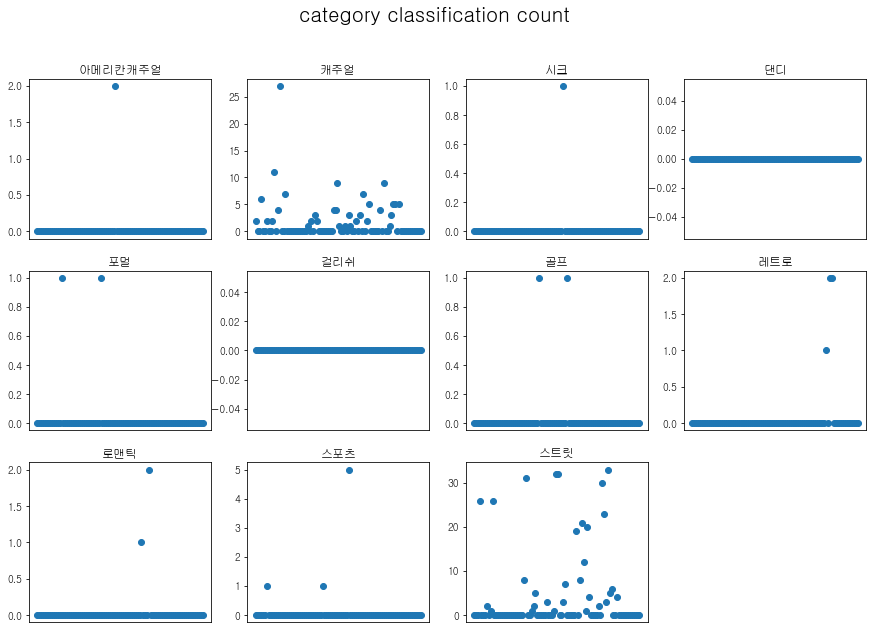
* 각 인플루언서, 카테고리별 유사성있는 태그의 개수를 시각화한 그래프다.
* 유사성있는 태그의 개수가 전체적으로 적어 표면적인 태그의 유사성으로는 의미있는 결과 검출이 어려워 보인다.

# 지환

## NLP

In [ ]:
pip install konlpy tqdm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm
from gensim.models import KeyedVectors
import numpy as np

df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/mss_train_tagamericancasual.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/mss_train_taggirlish.xlsx')

train_data = pd.concat([df1, df2], axis=0)
#print(train_data)

train_data.columns = ['c', 'a', 'product_name']
#print(train_data[:5]) # 상위 5개 출력

#print(len(train_data)) # 리뷰 개수 출력

# NULL 값 존재 유무
#print(train_data.isnull().values.any())

train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
#print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

##print(len(train_data)) # 리뷰 개수 출력



df1 = list(train_data.iloc[0])
df1 = df1[2]
df2 = list(train_data.iloc[1])
df2 = df2[2]
df3 = list(train_data.iloc[2])
df3 = df3[2]
df4 = list(train_data.iloc[3])
df4 = df4[2]
df5 = list(train_data.iloc[4])
df5 = df5[2]
df6 = list(train_data.iloc[5])
df6 = df6[2]
df7 = list(train_data.iloc[6])
df7 = df7[2]
df8 = list(train_data.iloc[7])
df8 = df8[2]
df9 = list(train_data.iloc[8])
df9 = df9[2]
df10 = list(train_data.iloc[9])
df10 = df10[2]
df11 = list(train_data.iloc[10])
df11 = df11[2]

df1 = ' '.join(word for word in df1)
df2 = ' '.join(word for word in df2)
df3 = ' '.join(word for word in df3)
df4 = ' '.join(word for word in df4)
df5 = ' '.join(word for word in df5)
df6 = ' '.join(word for word in df6)
df7 = ' '.join(word for word in df7)
df8 = ' '.join(word for word in df8)
df9 = ' '.join(word for word in df9)
df10 = ' '.join(word for word in df10)
df11 = ' '.join(word for word in df11)


df1 = df1.replace("' # ","")
df1 = df1.replace(" ","")
df1 = df1.replace(" ' ,"," ")
df1 = df1.replace("[","")
df1 = df1.replace("]","")
df1 = df1.replace("',"," ")
df1 = df1.replace("/"," ")

df2 = df2.replace("' # ","")
df2 = df2.replace(" ","")
df2 = df2.replace(" ' ,"," ")
df2 = df2.replace("[","")
df2 = df2.replace("]","")
df2 = df2.replace("',"," ")
df2 = df2.replace("/"," ")

df3 = df3.replace("' # ","")
df3 = df3.replace(" ","")
df3 = df3.replace(" ' ,"," ")
df3 = df3.replace("[","")
df3 = df3.replace("]","")
df3 = df3.replace("',"," ")
df3 = df3.replace("/"," ")

df4 = df4.replace("' # ","")
df4 = df4.replace(" ","")
df4 = df4.replace(" ' ,"," ")
df4 = df4.replace("[","")
df4 = df4.replace("]","")
df4 = df4.replace("',"," ")
df4 = df4.replace("/"," ")

df5 = df5.replace("' # ","")
df5 = df5.replace(" ","")
df5 = df5.replace(" ' ,"," ")
df5 = df5.replace("[","")
df5 = df5.replace("]","")
df5 = df5.replace("',"," ")
df5 = df5.replace("/"," ")


df6 = df6.replace("' # ","")
df6 = df6.replace(" ","")
df6 = df6.replace(" ' ,"," ")
df6 = df6.replace("[","")
df6 = df6.replace("]","")
df6 = df6.replace("',"," ")
df6 = df6.replace("/"," ")

df7 = df7.replace("' # ","")
df7 = df7.replace(" ","")
df7 = df7.replace(" ' ,"," ")
df7 = df7.replace("[","")
df7 = df7.replace("]","")
df7 = df7.replace("',"," ")
df7 = df7.replace("/"," ")


df8 = df8.replace("' # ","")
df8 = df8.replace(" ","")
df8 = df8.replace(" ' ,"," ")
df8 = df8.replace("[","")
df8 = df8.replace("]","")
df8 = df8.replace("',"," ")
df8 = df8.replace("/"," ")


df9 = df9.replace("' # ","")
df9 = df9.replace(" ","")
df9 = df9.replace(" ' ,"," ")
df9 = df9.replace("[","")
df9 = df9.replace("]","")
df9 = df9.replace("',"," ")
df9 = df9.replace("/"," ")


df10 = df10.replace("' # ","")
df10 = df10.replace(" ","")
df10 = df10.replace(" ' ,"," ")
df10 = df10.replace("[","")
df10 = df10.replace("]","")
df10 = df10.replace("',"," ")
df10 = df10.replace("/"," ")

df11 = df11.replace("' # ","")
df11 = df11.replace(" ","")
df11 = df11.replace(" ' ,"," ")
df11 = df11.replace("[","")
df11 = df11.replace("]","")
df11 = df11.replace("',"," ")
df11 = df11.replace("/"," ")






df1 = df1.split(' ')

df2 = df2.split(' ')

df3 = df3.split(' ')

df4 = df4.split(' ')

df5 = df5.split(' ')

df6 = df6.split(' ')

df7 = df7.split(' ')

df8 = df8.split(' ')

df9 = df9.split(' ')

df10 = df10.split(' ')

df11 = df11.split(' ')

data = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]


#train_data = pd.DataFrame(data, columns=['product_name'])




'''
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)

okt = Okt()

tokenized_data = []
for sentence in tqdm(data):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)
    #stopwords_removed_sentence
'''

'''
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

'''
model = Word2Vec(sentences = data, size = 100, window = 30, min_count = 1, workers = 4, sg = 1)

model.wv.vectors.shape
model.wv.save_word2vec_format('/content/drive/MyDrive/Colab Notebooks/KUIAI_NLP') # 모델 저장

loaded_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Colab Notebooks/KUIAI_NLP")
model = loaded_model

while True:
  k = input('>>> 첫번쨰 키워드를 입력해주세요 ')
  v = input('>>> 두번째 키워드를 입력해주세요 ')
  try:
    print('\n', model.wv.similarity(k,v)) #most_similar
  except:
    print('\n 데이터에 없습니다')

해쉬태그로 인플루언서의 패션 스타일을 유추하는 알고리즘. 무신사 태그에서 학습한 자연어처리 차원에서의 거리 유사도로 측정. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm
from gensim.models import KeyedVectors
import numpy as np
import copy

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

loaded_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Colab Notebooks/KUIAI_NLP")
model = loaded_model

def similarity(k,v):
  try:
    return model.wv.similarity(k,v)
  except:
    return 0
def preprocessing(df1):
  df1 = df1.replace("' # ","")
  df1 = df1.replace(" ","")
  df1 = df1.replace(" ' ,","")
  df1 = df1.replace("[","")
  df1 = df1.replace("]","")
  df1 = df1.replace("',","")
  df1 = df1.replace("/","")
  df1 = df1.replace("['\'\'","")
  df1 = df1.replace("\', \'","")
  df1 = df1.replace("'\'\']","")
  df1 = df1.replace('"', '')



  return df1
matrix = list(range(df1.shape[0]))
df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/instagram_tag.xlsx')

for i,v in enumerate(df1['tags']):
  v = list(v)
  v = ''.join(v)
  v = preprocessing(v)
  v = v.split("\'")
  matrix[i] = v

fashion_type = ['로맨틱', '스트릿', '스포츠', '댄디', '아메리칸 캐주얼', '시크', '레트로', '포멀', '골프', '캐주얼', '걸리시']
def compare(hashtag):
  temp = np.zeros(len(fashion_type))
  for i, f in enumerate(fashion_type):
    temp[i] = similarity(hashtag, f)
  return temp

result = []
for index, i in enumerate(matrix):
  score = np.zeros(len(fashion_type))
  for j in i:
    temp_score = compare(j)
    score = score + temp_score
  result.append(score)

for i in range(len(df1['tags'])):
  if i == 0:
    k = np.array(result[i])
  else:
    k = np.concatenate((k, np.array(result[i])), axis = 0)
k = k.reshape((-1,len(fashion_type)))
k = pd.DataFrame(k, columns = fashion_type)
k.insert(0,'ID',df1['account'])
print(k[20:25])
k.to_excel(r'/content/drive/MyDrive/Colab Notebooks/export_dataframe.xlsx', index=False)

<ipython-input-115-609cf587c356>:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  return model.wv.similarity(k,v)


                 ID       로맨틱       스트릿       스포츠        댄디  아메리칸 캐주얼  \
20     @c_eunnnnnnn  0.000000  0.000000  0.000000  0.000000       0.0   
21      @chaileeson  0.000000  0.000000  0.000000  0.000000       0.0   
22        @dbs.ycaa  4.815535  7.667614  8.389065  5.485940       0.0   
23         @dismas_  5.721834  8.652038  8.672019  6.446265       0.0   
24  @dosirak_hansol  0.000000  0.000000  0.000000  0.000000       0.0   

          시크       레트로        포멀        골프       캐주얼       걸리시  
20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
21  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
22  4.479423  5.374504  5.091610  8.103712  7.672818  5.503594  
23  5.413984  6.331092  6.029588  8.568262  8.829501  6.441041  
24  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  


**Deep Fashion Try On - 사용자의 사진에 옷을 입혀주는 딥러닝 모델**

아래는 모델 및 모델에 필요한 dependencies와 working directory 생성 코드

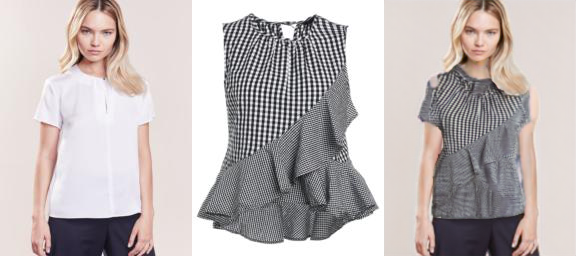

In [ ]:
!git clone https://github.com/kairess/ACGPN.git
%cd ACGPN
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq
import gdown
import numpy as np
from PIL import Image
import IPython
import gdown
import os
import sys
import time

from predict_pose import generate_pose_keypoints

!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git
!git clone https://github.com/levindabhi/U-2-Net.git

!gdown 1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko -O pose/pose_iter_440000.caffemodel


gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

%cd U-2-Net
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp

!gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

import u2net_load
import u2net_run

u2net = u2net_load.model(model_name='u2netp')

%cd ..

!mkdir checkpoints

gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx', output='checkpoints/ACGPN_checkpoints.zip', quiet=False)

!unzip checkpoints/ACGPN_checkpoints.zip -d checkpoints

Cloning into 'ACGPN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 165 (delta 21), reused 19 (delta 18), pack-reused 141
Receiving objects: 100% (165/165), 303.15 KiB | 11.66 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/ACGPN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 6.2 MB/s eta 0:00:00
Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (769/769), done.
remote: Compressing objects: 100% (579/579), done.
remote: Total 769 (delta 188), reused 720 (delta 179), pack-reused 0
Receiving objects: 100% (769/769), 3.80 MiB | 22.22 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Cloning into 'U-2-Net'...
remote: Enumerating objects: 822, done.
remote: Total 822 (delta 0), reused 0 (delta 0), pack-reused 822
Receiving objects: 100% (822/822), 30.72 MiB | 16.98 MiB/s, done.
Resolv

Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /content/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:11<00:00, 23.3MB/s]

/content/ACGPN/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists


Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 259MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /content/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:03<00:00, 55.5MB/s]
...load U2NEP---4.7 MB
/content/ACGPN


Downloading...
From: https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
To: /content/ACGPN/checkpoints/ACGPN_checkpoints.zip
100%|██████████| 524M/524M [00:07<00:00, 68.4MB/s]


Archive:  checkpoints/ACGPN_checkpoints.zip
   creating: checkpoints/label2city/
  inflating: checkpoints/label2city/latest_net_G.pth  
  inflating: checkpoints/label2city/latest_net_G1.pth  
  inflating: checkpoints/label2city/latest_net_G2.pth  
  inflating: checkpoints/label2city/latest_net_U.pth  
  inflating: checkpoints/label2city/opt.txt  


/content/ACGPN/inputs/cloth 경로에 입히고 싶은 이미지를 넣고,

/content/ACGPN/inputs/img/모델.jpg 경로에 사용자의 사진을 넣고 

실행시키면 사용자 사진에 옷을 합성 시켜준다. 

inputs/cloth/시크.jpg
Generating mask for: cloth_1674058359.png
Saving output at Data_preprocessing/test_edge/cloth_1674058359.png
100% 1/1 [00:01<00:00,  1.75s/it]
File saved at Data_preprocessing/test_pose/img_1674058367_keypoints.json
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encod

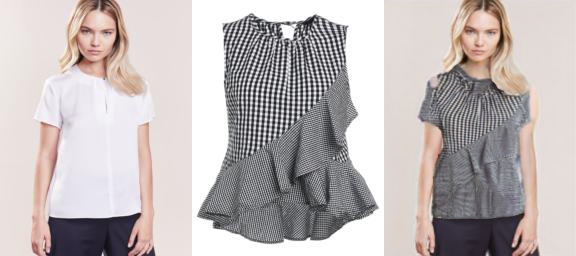

In [ ]:
sorted(os.listdir('inputs/cloth'))

cloth_name = f'cloth_{int(time.time())}.png'

cloth_path = os.path.join('inputs/cloth', sorted(os.listdir('inputs/cloth'))[0])

print(cloth_path)


cloth = Image.open(cloth_path)
cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')
cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')

Image.open(f'Data_preprocessing/test_edge/{cloth_name}')


sorted(os.listdir('inputs/img'))


img_name = f'img_{int(time.time())}.png'

img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])
img = Image.open(img_path)
img = img.resize((192,256), Image.BICUBIC)

img_path = os.path.join('Data_preprocessing/test_img', img_name)
img.save(img_path)

!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))
generate_pose_keypoints(img_path, pose_path)


!rm -rf Data_preprocessing/test_pairs.txt
with open('Data_preprocessing/test_pairs.txt', 'w') as f:
    f.write(f'{img_name} {cloth_name}')

!python test.py

output_grid = np.concatenate([
    np.array(Image.open(f'Data_preprocessing/test_img/{img_name}')),
    np.array(Image.open(f'Data_preprocessing/test_color/{cloth_name}')),
    np.array(Image.open(f'results/test/try-on/{img_name}'))
], axis=1)

image_grid = Image.fromarray(output_grid)

image_grid


In [ ]:
from google.colab import drive 
drive.mount('/content/drive') #구글 드라이브 마운트

Mounted at /content/drive


In [ ]:
import shutil
shutil.rmtree('/content/ACGPN')#전체 디렉토리 삭제

In [ ]:
cd /content/ #working directory로 이동

##인스타그램 이미지 jpg 변환 및 배경 제거

In [ ]:
from pathlib import Path
import rembg
from rembg import new_session
import os
from PIL import Image

file_list = os.listdir('insta')
#각 인플루언서 폴더 내에 webp 이미지를 jpg로 변환
for i in file_list:
    path = f"C:/Users/user/Desktop/kuiai/insta/{i}/images"

    file_list_insta = os.listdir(path)
    for j in file_list_insta:
        if(j[-1]) == 'p':
            im=Image.open(f'{path}/{j}').convert('RGB')
            im.save(f'{path}/{j}.jpg', 'jpeg')
            print(f'changed {j}')
            

#rembg 라이브러리 이용 배경 제거 후 흰색으로 변경

def process(session, image, *, size=None, bgcolor='white'):
    if size is not None:
        image = image.resize(size)
    else:
        size = image.size
    result = Image.new("RGB", size, bgcolor)
    out = rembg.remove(image, session=session)
    result.paste(out, mask=out)
    return result

#로컬 디렉토리 지정, 인플루언서 배경 제거 후 인플루언서명+숫자로 저장
for i in file_list:
    path = f"C:/Users/user/Desktop/kuiai/insta/{i}/images"

    file_list_insta = os.listdir(path)
    n=0
    session = new_session()

    for path_in in Path(f'{path}').glob('*.jpg'):
        path_out = path_in.parent / f"{i}_{n}-out.jpg"
        if path_out.exists():
            continue
        with Image.open(path_in) as img:
            out = process(session, img, size=(640, 640), bgcolor='#FFFFFF') #배경색 흰색
            out.save(path_out)
            n+=1


##YOLOv5 이용 학습

In [ ]:
#Roboflow 사이트에서 data 받아오기
!curl -L "https://app.roboflow.com/ds/VmuyK6ufFS?key=8lYZQtEMuz" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: train/images/107_girlish_jpg.rf.7d7bd6052758aacefc427bdc731b8d0a.jpg  
 extracting: train/images/107_girlish_jpg.rf.993081f12dd18dc70526bec11dce66d5.jpg  
 extracting: train/images/107_retro_jpg.rf.b5995de96c2a7fcf998138be6136a976.jpg  
 extracting: train/images/107_retro_jpg.rf.d3d65d96c688fe2eef340824824e7dcf.jpg  
 extracting: train/images/107_romantic_jpg.rf.10273417986370b4bbe3ebbca8efc9b0.jpg  
 extracting: train/images/107_romantic_jpg.rf.7fe31c9ab7b4807ca25ccdb5c4eb674a.jpg  
 extracting: train/images/107_sports_jpg.rf.118560f4da9b7d9055583fef551410b2.jpg  
 extracting: train/images/107_sports_jpg.rf.a65a1533e3221fd8d97824f1e672a894.jpg  
 extracting: train/images/107_street_jpg.rf.27eb110c462237ac18b99f239b3a5fb2.jpg  
 extracting: train/images/107_street_jpg.rf.da46d716d1f6c0797a51b04a06ac7581.jpg  
 extracting: train/images/108_casual_jpg.rf.050f50c1cd9fe465ae8746c374369436.jpg  
 extracting: train/images/108_casual_jpg.rf.6a0

In [ ]:
#mss_data 이름으로 새로운 폴더 생성
!mkdir mss_data

In [ ]:
#mss_data로 앞서 압축해제한 파일 이동
!mv "/content/train" "/content/mss_data"
!mv "/content/valid" "/content/mss_data"
!mv "/content/test" "/content/mss_data"
!mv "/content/data.yaml" "/content/mss_data"
!mv "/content/README.roboflow.txt" "/content/mss_data"
!mv "/content/README.dataset.txt" "/content/mss_data"

In [ ]:
#YOLOv5 clone
%cd /content
!git clone https://github.com/ultralytics/yolov5.git

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 14995, done.
remote: Total 14995 (delta 0), reused 0 (delta 0), pack-reused 14995
Receiving objects: 100% (14995/14995), 14.02 MiB | 14.27 MiB/s, done.
Resolving deltas: 100% (10286/10286), done.


In [ ]:
#필요 패키지 설치
%cd /content/yolov5
!pip install -r requirements.txt

/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.4 MB/s eta 0:00:00


In [ ]:
#data.yaml 확인(10개의 class)
%cat /content/mss_data/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 10
names: ['americancasual', 'casual', 'chic', 'dandy', 'formal', 'girlish', 'retro', 'romantic', 'sports', 'street']

roboflow:
  workspace: ime
  project: mss-zyu34
  version: 5
  license: CC BY 4.0
  url: https://universe.roboflow.com/ime/mss-zyu34/dataset/5

In [ ]:
#train/valid data 수 확인
%cd /
from glob import glob

train_list = glob('/content/mss_data/train/images/*.jpg')
valid_list = glob('/content/mss_data/valid/images/*.jpg')

print(len(train_list), len(valid_list))

/
2244 320


In [ ]:
#train/vaid data 파일 주소 txt로 저장
with open('/content/mss_data/train.txt', 'w') as tmp:
  tmp.write('\n'.join(train_list) + '\n')

with open('/content/mss_data/valid.txt', 'w') as tmp:
  tmp.write('\n'.join(valid_list) + '\n')

In [ ]:
#앞서 저장한 파일 주소로 data.yaml에서 val/train 재설정
import yaml

with open('/content/mss_data/data.yaml', 'r') as f:
  data = yaml.safe_load(f)

print(data)

data['train'] = '/content/mss_data/train.txt'
data['val'] = '/content/mss_data/valid.txt'

with open('/content/mss_data/data.yaml', 'w') as f:
  yaml.dump(data, f)

print(data)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 10, 'names': ['americancasual', 'casual', 'chic', 'dandy', 'formal', 'girlish', 'retro', 'romantic', 'sports', 'street'], 'roboflow': {'workspace': 'ime', 'project': 'mss-zyu34', 'version': 5, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/ime/mss-zyu34/dataset/5'}}
{'train': '/content/mss_data/train.txt', 'val': '/content/mss_data/valid.txt', 'test': '../test/images', 'nc': 10, 'names': ['americancasual', 'casual', 'chic', 'dandy', 'formal', 'girlish', 'retro', 'romantic', 'sports', 'street'], 'roboflow': {'workspace': 'ime', 'project': 'mss-zyu34', 'version': 5, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/ime/mss-zyu34/dataset/5'}}


In [ ]:
%cd /content/yolov5/

#모델 학습(이미지 크기 640, 배치 64, 에포크 150, data.yaml 데이터를 yolov5s 모델로 검출, mss_yolov5s_results 폴더로 결과 저장)
!python train.py --img 640 --batch 64 --epochs 150 --data /content/mss_data/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name mss_yolov5s_results

/content/yolov5
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/mss_data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=mss_yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-71-gc442a2e Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t

In [ ]:
#test list 저장
test_list = glob('/content/mss_data/test/images/*.jpg')

#test 이미지 파일 경로 txt 파일로 저장
with open('/content/mss_data/test.txt', 'w') as tmp:
  tmp.write('\n'.join(test_list) + '\n')


from IPython.display import Image
import os

#인덱스 바꿔가면서 여러 사진에 대해 결과 확인
test_img_path = test_list[95]

#앞서 도출해낸 best weight으로 검출 실시(yolov5/runs/detect/exp에 결과 저장됨) --source "{test_img_path}"
!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/mss_yolov5s_results/weights/best.pt --img 640 --conf 0.4 --source /content/3005808055829880186.out.jpg --save-txt --save-conf

detect: weights=['/content/yolov5/runs/train/mss_yolov5s_results/weights/best.pt'], source=/content/3005808055829880186.out.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-71-gc442a2e Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7037095 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/3005808055829880186.out.jpg: 640x512 (no detections), 12.4ms
Speed: 0.5ms pre-process, 12.4ms inference, 0.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp11
0 labels saved to runs/detect/exp11/labels


In [ ]:
from google.colab import files
#best.pt 파일 다운로드
files.download('/content/yolov5/runs/train/mss_yolov5s_results/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
file_list = os.listdir('/content/drive/MyDrive/kuiai')
print(file_list)

for i in file_list:
  !python /content/yolov5/detect.py --weights /content/best.pt --img 640 --conf 0.4 --source '/content/drive/MyDrive/kuiai/{i}' --save-txt --save-conf

['@__02x02', '@__my_t__', '@__v.yuum_look__', '@_jongh0', '@_mgi_closet_', '@_yourthen', '@_zia_mood', '@0nefence', '@1ungwoo', '@59seok', '@98.c_project', '@166.ootd', '@337janggoon', '@amourfor_u', '@antmousbe9', '@ap.s_fi1st', '@arcco_iris_', '@ba_serin_e', '@bacajini', '@bbo9ni', '@bejoon0', '@belleofcloset', '@bloggerbok', '@by_he.nique', '@campo_look', '@c_eunnnnnnn', '@chaileeson', '@d_soms', '@dbs.ycaa', '@dismas_', '@dosirak_hansol', '@e_wolly', '@eungil_j', '@geol_dong', '@grey_woo9', '@hamnihouse', '@hawl_o.s', '@hmm.__.u', '@hodu__jwan', '@hotneul', '@hwi____ii', '@j0ng_wo0', '@jelly_wony', '@jess.02.23', '@jin.wonder', '@jin_pyo_is', '@jindalorian', '@jung_staas', '@k_8_8bsoo', '@kimchiz_man', '@kimyannnnngh', '@kj_m.w', '@kxyxn', '@lamode.seoul', '@lil_0uzi_vert', '@loolinmx', '@lxx.s.y_', '@m_n__day', '@malko_bee', '@mavlfit', '@mini.d31', '@moodonx2', '@my_own_way_____', '@odor_bubu', '@one_r_k', '@oneh6_', '@oohsehun', '@oytoyt_', '@ro.seon', '@rozley._.y', '@rupinydai

In [ ]:
from google.colab import files
#100번의 detection에서 생성된 100개의 exp 결과 zip 파일로 압축하여 다운로드
!zip -r /content/file.zip /content/yolov5/runs/detect
files.download("/content/file.zip")

  adding: content/yolov5/runs/detect/ (stored 0%)
  adding: content/yolov5/runs/detect/exp/ (stored 0%)
  adding: content/yolov5/runs/detect/exp/@__02x02_15-out.jpg (deflated 23%)
  adding: content/yolov5/runs/detect/exp/@__02x02_4-out.jpg (deflated 14%)
  adding: content/yolov5/runs/detect/exp/@__02x02_8-out.jpg (deflated 25%)
  adding: content/yolov5/runs/detect/exp/@__02x02_17-out.jpg (deflated 23%)
  adding: content/yolov5/runs/detect/exp/@__02x02_24-out.jpg (deflated 24%)
  adding: content/yolov5/runs/detect/exp/@__02x02_25-out.jpg (deflated 20%)
  adding: content/yolov5/runs/detect/exp/@__02x02_27-out.jpg (deflated 25%)
  adding: content/yolov5/runs/detect/exp/@__02x02_13-out.jpg (deflated 28%)
  adding: content/yolov5/runs/detect/exp/@__02x02_1-out.jpg (deflated 23%)
  adding: content/yolov5/runs/detect/exp/@__02x02_5-out.jpg (deflated 29%)
  adding: content/yolov5/runs/detect/exp/@__02x02_23-out.jpg (deflated 20%)
  adding: content/yolov5/runs/detect/exp/@__02x02_20-out.jpg (de

NameError: ignored

##다운로드한 라벨 파일 태그별 빈도 csv로 변환

In [ ]:
import os

# 텍스트 파일이 모여있는 폴더
directory_head = "./detect/exp"

#exp, exp2, exp3, ... 순으로 가기에 다음과 같이 리스트 설정
list_tmp = [str(i) for i in range(2,101)]
list_tmp.insert(0,'')

#인플루언서 id로 txt 파일 리턴하기 위해 n값 설정, 인플루언서 id 담은 리스트 생성
n=0
taglist = ['@__02x02', '@__my_t__', '@__v.yuum_look__', '@_jongh0', '@_mgi_closet_',
           '@_yourthen', '@_zia_mood', '@0nefence', '@1ungwoo', '@59seok', '@98.c_project',
           '@166.ootd', '@337janggoon', '@amourfor_u', '@antmousbe9', '@ap.s_fi1st', '@arcco_iris_',
           '@ba_serin_e', '@bacajini', '@bbo9ni', '@bejoon0', '@belleofcloset', '@bloggerbok',
           '@by_he.nique', '@campo_look', '@c_eunnnnnnn', '@chaileeson', '@d_soms', '@dbs.ycaa',
           '@dismas_', '@dosirak_hansol', '@e_wolly', '@eungil_j', '@geol_dong', '@grey_woo9',
           '@hamnihouse', '@hawl_o.s', '@hmm.__.u', '@hodu__jwan', '@hotneul', '@hwi____ii', '@j0ng_wo0',
           '@jelly_wony', '@jess.02.23', '@jin.wonder', '@jin_pyo_is', '@jindalorian', '@jung_staas',
           '@k_8_8bsoo', '@kimchiz_man', '@kimyannnnngh', '@kj_m.w', '@kxyxn', '@lamode.seoul',
           '@lil_0uzi_vert', '@loolinmx', '@lxx.s.y_', '@m_n__day', '@malko_bee', '@mavlfit',
           '@mini.d31', '@moodonx2', '@my_own_way_____', '@odor_bubu', '@one_r_k', '@oneh6_',
           '@oohsehun', '@oytoyt_', '@ro.seon', '@rozley._.y', '@rupinydaily', '@s.s_jun', '@s_uz_.zzy__2',
           '@shura_twins_korea', '@siaestival', '@skuukzky', '@slglf', '@so_h_appy', '@so_j2',
           '@so_love_so_', '@sualboys', '@sympa_young', '@tlrou.vee', '@tt__yl', '@uuuuk_2_',
           '@velyjuu', '@win.on_', '@wnsgurrha', '@xixxeeonx_4', '@y._.dulcet', '@y_mood_h',
           '@yangkoon__dl', '@yeenstyle_', '@yj_mark', '@ys971003__', '@yulkeem___', '@yummy.__.do',
           '@z___meme', '@zxcvr0626', '@ruri.kim']

#exp 폴더의 labels 폴더 디렉토리로 지정
for j in list_tmp:
    directory = f'{directory_head}{j}/labels'
    #인플루언서 이름으로 파일명 설정
    outfile_name = f"{taglist[n]}.txt"

    #결과 파일 생성
    out_file = open(outfile_name, 'w')

    #폴더 내 파일명 list 확인 후 조회
    input_files = os.listdir(directory)
    for filename in input_files:
        #확장자 확인
        if ".txt" not in filename:
            continue

        #txt 읽기
        file = open(directory + "/" + filename)

        #파일 내용 첫 숫자(탐지된 label 정보) 저장
        content = file.read()
        content = content.split()[0]

        #문자열로 저장된 내용을 파일에 쓰기
        out_file.write(content + " ")
        file.close()

    out_file.close()
    #다음 id로 진행
    n+=1

print("병합 완료")

#만들어진 메모장 파일에서 count 후 dataframe에 저장
import pandas as pd

#빈 dataframe 생성(11개의 column)
df = pd.DataFrame(columns=range(0,11))
for i in range(0,100):
    #초기화 및 id를 list_df 가장 앞에 저장
    list_df = [f'{taglist[i]}']
    #메모장 열어서 리스트로 저장
    with open(f'{taglist[i]}.txt', 'r') as f:
        list_one = list(map(int,f.read().split()))
        print(list_one)
    #숫자(label) 별 등장 count하여 list_df에 저장
    for j in range(0,10):
        list_df.append(list_one.count(j))
    print(list_df)
    #dataframe에 list_df row로 추가
    df.loc[i] = list_df

#dataframe column 이름 재설정
fashiontag = ['id','americancasual','casual','chic','dandy','formal','girlish','retro','romantic','sports','street']
df.columns = fashiontag
#csv로 저장
df.to_csv('influ_tag_result.csv')

위에서 취합한 정보들의 가중치를 linear regression을 통해 추출해낸다. 

이후 그 가중치를 이용해 가장 적합한 패션 스타일을 도출해낸다. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm
from gensim.models import KeyedVectors
import numpy as np
import copy
import torch as torch


pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/linear regression/export_dataframe (2).xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/linear regression/influ_tag_result.xlsx')
df3 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/linear regression/tag_category_count_df.xlsx')
df2 = df2.drop(['influ_tag_result'], axis = 1)
name = ['ID', '아메리칸 캐주얼', '캐주얼', '시크', '댄디', '포멀', '걸리시', '레트로', '로맨틱', '스포츠', '스트릿']
df2.columns = name
df2 = df2.iloc[1:]
df1 = df1[['ID', '아메리칸 캐주얼', '캐주얼', '시크', '댄디', '포멀', '걸리시', '레트로', '로맨틱', '스포츠', '스트릿', '골프']]
df1.columns = ['ID', '아메리칸 캐주얼', '캐주얼', '시크', '댄디', '포멀', '걸리시', '레트로', '로맨틱', '스포츠', '스트릿', '골프']


df3 = df3[['account', '아메리칸캐주얼', '캐주얼', '시크', '댄디', '포멀', '걸리쉬', '레트로', '로맨틱', '스포츠', '스트릿', '골프']]
df3.columns = ['ID', '아메리칸 캐주얼', '캐주얼', '시크', '댄디', '포멀', '걸리시', '레트로', '로맨틱', '스포츠', '스트릿', '골프']

df_INNER_JOIN_1 = pd.merge(df1, df2, left_on='ID', right_on='ID', how='inner')
X = pd.merge(df_INNER_JOIN_1, df3, left_on='ID', right_on='ID', how='inner')


X = X[:10]
X = X[['아메리칸 캐주얼', '캐주얼', '시크', '댄디', '포멀', '걸리시', '레트로', '로맨틱', '스포츠', '스트릿','아메리칸 캐주얼_x', '캐주얼_x', '시크_x', '댄디_x', '포멀_x', '걸리시_x', '레트로_x', '로맨틱_x', '스포츠_x', '스트릿_x', '아메리칸 캐주얼_y', '캐주얼_y', '시크_y', '댄디_y', '포멀_y', '걸리시_y', '레트로_y', '로맨틱_y', '스포츠_y', '스트릿_y']]

list_of_superman = ['아메리칸 캐주얼', '캐주얼', '시크', '댄디', '포멀', '걸리시', '레트로', '로맨틱', '스포츠', '스트릿']
Y = np.random.randint(0,10, size = 10)



# 데이터셋 텐서로 선언

x_data = X.values.tolist()
y_data = Y

# 데이터
x_train = torch.FloatTensor(x_data)
y_train = torch.FloatTensor(y_data)

# 모델 초기화
W = torch.zeros(30, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = torch.optim.SGD([W, b], lr=0.001)

nb_epochs = 100 # 원하는만큼 경사 하강법을 반복


for epoch in range(nb_epochs + 1):

    # H(x) 계산

    hypothesis = torch.matmul(x_train, W) + b
    # cost 계산
    cost = torch.mean((hypothesis - y_train) ** 2)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 30 == 0:
        print(W, b, cost.item()
        )

k = [44.865428, 31.145874, 34.794663, 33.804293, 35.802945, 34.615370, 32.484586, 40.376890, 40.955929, 2, 0, 0, 0, 0, 1, 2, 0, 4, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0]
k = torch.tensor(k)

a = torch.matmul(k, W.detach()) + b.detach()

print(f'  \n당신의 패션 스타일은 {list_of_superman[int(a)]}입니다!!')

tensor([0.0000, 0.0182, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0018,
        0.0516, 0.0000, 0.0696, 0.0521, 0.0581, 0.0562, 0.0575, 0.0558, 0.0538,
        0.0560, 0.0602, 0.0262, 0.0244, 0.0032, 0.0010, 0.0046, 0.0172, 0.0266,
        0.0016, 0.1044, 0.0548], requires_grad=True) tensor([0.0122], requires_grad=True) 43.70000076293945
tensor([ 0.0000,  0.0060,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0256, -0.1987,  0.0000, -0.0161,  0.0242,  0.0135,  0.0200,  0.0123,
         0.0096,  0.0206, -0.0626, -0.0441,  0.2557,  0.1500,  0.0465, -0.0056,
         0.0425,  0.1488,  0.1398,  0.0271,  0.4947,  0.2921],
       requires_grad=True) tensor([0.0837], requires_grad=True) 4.849639892578125
tensor([ 0.0000,  0.0095,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0373, -0.2739,  0.0000, -0.0226,  0.0383,  0.0238,  0.0331,  0.0206,
         0.0136,  0.0345, -0.0918, -0.0661,  0.3355,  0.1391,  0.0710, -0.0238,
         0.0464,  0.1990,  

## 인플루언서 카테고리 분류 Dataframe

## 실제 데이터 흐름

In [ ]:
# 준비과정
# -----
# 무신사 사진 크롤링 -> yolo모델학습
# 무신사 태그 크롤링 -> nlp모델학습
# get_best_match로 인플루언서별 코디 카테고리와 보유한 유사한 태그 개수 카운트
# 각 인플루언서별 사진을 학습된 모델을 이용하여 인플루언서를 코디 카테고리로 분류
# -----

# 예시 input
# url = https://www.musinsa.com/app/goods/2702396 (무신사상품url)
# name = name

#funtion 실행에 앞서 YOLOv5 패키지/요구 라이브러리 설치
#git clone
%cd
os.system('!git clone https://github.com/ultralytics/yolov5.git') 
#필요 패키지 설치
%cd /yolov5
os.system('!pip install -r requirements.txt')
#YOLOv5 detection 결과 구하기 위해 필요한 함수 실행 횟수 계산
runcount = 0



# URL을 통해 사진, 태그정보 수집
def musinsa(name,input) : 
  #pacakage import
  from urllib.request import urlopen
  from bs4 import BeautifulSoup
  from fake_useragent import UserAgent
  import pandas as pd
  import numpy as np
  import requests
  import openpyxl
  import time
  from multiprocessing import Process
  import multiprocessing as mp
  import os
  #폴더생성 함수
  def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

  ua = UserAgent()
  #크롤러의 user-agent 정의
  headers = {
      'User-agent' : ua.ie,
      'referer' : "https://www.musinsa.com/"
  }
  #input된 url의 html 정보를 가져옴
  res_each = requests.get(input, headers=headers)
  soup = BeautifulSoup(res_each.content, 'html.parser')
  #user의 name에 따른 폴더를 생성
  createFolder('./img/' + name)
  img_url = []
  try:
    img_street_Url = soup.select('img.street_img')
    for img in img_street_Url :
        img_url.append(img['src'])
  except:
    pass

  try:
    img_brand_Url = soup.select('img.staff_img')
    for img in img_brand_Url :
        img_url.append(img['src'])
  except:
    pass

  n=0
  try:
    for link in img_url :
      with urlopen(f'https:{link}') as f:
        with open('./img/'+ name + '/' + n + '.jpg', 'wb') as h:  # w - write b - binary
          img = f.read()
          h.write(img)
        n+= 1
  except:
    pass

  tag_data = []
  # Find link elements on the page
  tags = soup.select('a.ui-tag-list__item')
  for e_tag in tags:
      tag_data.append(e_tag.string)
  
  #return tag_data

  tag_list = musinsa(name, url) #tag_list에 태그 정보 저장

  # 무신사 사진 스냅샷을 yolo모델로 분류한 결과 -> 1
  def identifyPic(pic_address): #디렉토리 내 이미지 주소 - pic_address
    label_list = ['americancasual','casual','chic','dandy','formal','girlish','retro','romantic','sports','street']
    #저장된 YOLOv5 모델로 detect, 드라이브에 저장된 weights 이용
    os.system(f'!python /yolov5/detect.py --weights /best.pt --img 640 --conf 0.4 --source {pic_address} --save-txt --save-conf')
    #실행될 때마다 exp 뒤 숫자가 증가, 그에 따른 주소 조건문(runcount는 musinsa function 외부에서 0으로 정의됨)
    if runcount == 0:
      label_addr = '/yolov5/runs/detect/exp/labels'
      label_txt = os.listdir(label_addr)
    else:
      label_addr = f'/yolov5/runs/detect/exp{runcount+1}/labels'
      label_txt = os.listdir(label_addr)
    
    #label을 탐지하지 못했다면 None값 return
    if len(label_txt)==0:
      return None
    #label을 탐지하였다면 사진마다 탐지한 label을 list로 return
    else:
      label_detected=[]
      for filename in label_txt:
        #label 확인
        file = open(label_addr + "/" +filename)
        content = file.read().split()[0]
        content = int(content)
        #label 숫자를 실제 label로 변환하여 반환할 list에 append
        label_detected.append(label_list[content])
    return label_detected

  identifyPic_df = pd.DataFrame(data = identifyPic('./img/'+name), index = [name], columns=['아메리칸 캐주얼','캐주얼','시크','댄디','포멀','걸리시','레트로','로맨틱','스포츠','스트릿'])
  return identifyPic_df
print(musinsa('me', 'https://www.musinsa.com/app/goods/2702396'))
  # 인플루언서의 태그 중 카테고리명과의 표면적 유사도가 있는 태그의 개수 dataframe
similarity = pd.read_excel('./tag_category_count_df.xlsx')  

  # 태그정보를 지환's nlp모델로 분류한 결과 -> 2



  # 1과 2 합산 (가중치?)


# 유저의 경우
# 
'''
def insta(id, pw, name) : 
    #pacakage import
    from urllib.request import urlopen
    from bs4 import BeautifulSoup
    from fake_useragent import UserAgent
    import pandas as pd
    import numpy as np
    import requests
    import openpyxl
    import time
    import os
    import multiprocessing as mp
    from multiprocessing import Pool, Process
    import threading
    import time
    import datetime
    from urllib.parse import quote_plus
    from selenium import webdriver as wd
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from selenium.webdriver.common.keys import Keys
    from selenium.webdriver.chrome.options import Options
    import openpyxl

    user_id=id
    user_passwd=pw
    driver_path="~/chromedriver"
    instagram_id_name="username"
    instagram_pw_name="password"
    instagram_login_btn='//*[@id="loginForm"]/div/div[3]/button'

    options = Options()
    options.add_argument(f'user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36')
    driver = wd.Chrome(options=options)
    stop_words = ['#인스타패션', '#패션스타그램', '#데일리코디', '#데일리패션', '#ootd', '#데일리', '#daily', '#dailylook', '#자체제작', '#쇼핑몰', '#자체제작쇼핑몰' 
                        ,'#코디모음', '#오오티디', '#이벤트', '#할인', '#좋아요', '#좋반', '#좋아요반사', '#오늘의코디']

    login_url = "https://www.instagram.com/accounts/login/"
    driver.get(login_url)
    time.sleep(8)

    #instagram으로 로그인
    try:
        instagram_id_form = driver.find_element(By.NAME, instagram_id_name)
        instagram_id_form.send_keys(user_id)
        time.sleep(3)

        instagram_pw_form = driver.find_element(By.NAME, instagram_pw_name)
        instagram_pw_form.send_keys(user_passwd)
        time.sleep(3)
            
        login_ok_button = driver.find_element(By.XPATH, instagram_login_btn)
        login_ok_button.click()
        is_login_success = True
        print("instagram login success")
    except:
        print("instagram login fail")
        is_login_success = False

    time.sleep(10)

    #폴더생성 함수
    def createFolder(directory):
        try:
            if not os.path.exists(directory):
                os.makedirs(directory)
        except OSError:
            print('Error: Creating directory. ' + directory)

    next_name = 'div._aaqg._aaqh > button'
    tag_name = 'span._aacl._aaco._aacu._aacx._aad7._aade > a'
    body = '//div[@class="_a9zn _a9zo"]//span[@class="_aacl _aaco _aacu _aacx _aad7 _aade"]'
    image_name = '//div[@class="_ab8w  _ab94 _ab99 _ab9h _ab9k _ab9p _abcm"]//img'
    more_btn = '//li[@class="_a9yg"]//button'
    try :
        url = 'https://www.instagram.com/'+name+'/'
        driver.get(url)
        time.sleep(10)
    except :
        print('not exist account')
        pass

        #tag 저장
    try :
        driver.find_element(By.CSS_SELECTOR,'div._aabd._aa8k._aanf').click()
    except :
        print('no Feed')
        return

    p=0
    for i in range(10):         
        try :                
            # 해쉬태그 데이터 기록
            # 답글 더보기 버튼 클릭
            morelist = driver.find_elements(By.XPATH, more_btn)
            for t in range(len(morelist)) :
                morelist[t].send_keys(Keys.ENTER)
                time.sleep(3)
            time.sleep(10)
        except :
            print('no more button')
            error += 1
            pass
        user_tag = []
        try :        
            # 해쉬태그가 있는 element들을 모아서 list에 저장
            list_ = driver.find_elements(By.CSS_SELECTOR, tag_name)
        
            hashtag_data = []

            for k in range(len(list_)):
                hashtag = list_[k].text #각각의 element에서 text 추출
                hashtag_data.append(hashtag)
            
            #의미없는 태그를 제거
            temp_tags = [hashtag for hashtag in hashtag_data if (hashtag not in stop_words) & (not hashtag.startswith('@'))]
            instagram_tags = []
            #중복된 태그를 제거
            [instagram_tags.append(x) for x in temp_tags if x not in instagram_tags]
            tag_data = instagram_tags
        except :
            print('no tag')
            error += 1
            pass
        try :
            createFolder('./img/'+ name)

            imgUrl = driver.find_element(By.XPATH, image_name).get_attribute('src')
            with urlopen(imgUrl) as f :
                with open('./img/' +  name + '/' + str(i) + '.jpg', 'wb') as h :
                    img = f.read()
                    h.write(img)
        except :
            error += 1
            pass
        user_tag.append(tag_data)
        try :
            WebDriverWait(driver,5).until(EC.presence_of_element_located((By.CSS_SELECTOR, next_name)))
            driver.find_element(By.CSS_SELECTOR, next_name).send_keys(Keys.ENTER)
            time.sleep(3)
        except :
            print('error occur')
            error += 1
            pass
    return user_tag[0]
  #insta(instaid, pw, account_name) * 사진 10장과 계정명 반환
#
#

# output = 
# print(output)
'''